# Transformaciones Geométricas

En este notebook aprenderás como implementar transformaciones geométricas sobre una imagen.

## Rotación

Operaciones comunes en visión artificial son transformar las imágenes. Veamos como rotamos una imagen usando una matriz de transformación e
interpolación bilineal.

In [ ]:
import cv2
import numpy as np
import math
import plotly.express as px
import plotly

In [ ]:
!wget https://ivan-sipiran.com/downloads/Imagenes.zip
!unzip Imagenes.zip

--2025-08-29 19:19:20--  https://ivan-sipiran.com/downloads/Imagenes.zip
Resolving ivan-sipiran.com (ivan-sipiran.com)... 66.96.149.31
Connecting to ivan-sipiran.com (ivan-sipiran.com)|66.96.149.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30654084 (29M) [application/zip]
Saving to: ‘Imagenes.zip.1’

Imagenes.zip.1      100%[===================>]  29.23M  10.0MB/s    in 2.9s    

2025-08-29 19:19:25 (10.0 MB/s) - ‘Imagenes.zip.1’ saved [30654084/30654084]

Archive:  Imagenes.zip
replace Imagenes/20191123_093200.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
"""
Recibe:
- I: Imagen de entrada (matriz de numpy)
- coord: coordenada transformada

Hace:
- Revisa si el punto está dentro de la imagen (si no, devuelve negro).
- Busca los 4 píxeles vecinos alrededor de la cordenada real.
- Interpola bilinealmente (en x e y).

Devuelve: Coordenanda interpolada bilinealmente
"""

def interpolar(I, coord):
    # Si la coordenada está fuera de la imagen devuelve 0 (negro)
    if coord[0] < 0 or coord[0] > (I.shape[1]-1) or coord[1] < 0 or coord[1] > (I.shape[0] - 1):
        return 0

    # Encuentra los 4 píxeles vecinos que rodean a un punto real.
    minx = math.floor(coord[0].item())
    maxx = math.ceil(coord[0].item())
    miny = math.floor(coord[1].item())
    maxy = math.ceil(coord[1].item())

    # Que tan lejos está el punto dentro de la celda.
    dx = coord[0].item() - minx
    dy = coord[1].item() - miny

    # 4 vecinos
    val1 = I[miny,minx]
    val2 = I[miny,maxx]
    val3 = I[maxy,maxx]
    val4 = I[maxy,minx]

    # Interpola en x (horizontal)
    val11 = val1*(1-dx) + dx*val2
    val22 = val4*(1-dx) + dx*val3

    # Interpola en y (vertical)
    return val22*(1-dy) + dy*val11

In [ ]:
"""
Recibe:
- I: Imagen de entrada (matriz de numpy)
- centro: punto alrededor del cual rotamos (x,y)
- angulo: ángulo de rotación
- dim_salida: tamaño de salida de la imagen

Hace:
- Transformaciones geométricas con matrices homogenéas (3x3).
- Mapeo inverso con interpolación para evitar huecos
(¿de qué posición de la entrada proviene este píxel?).

Devuelve: Imagen rotada y escalada
"""

def rotarImagen(I, centro, angulo, dim_salida):
    salida = np.zeros(dim_salida, dtype=np.uint8)
    angle = np.radians(angulo)

    # LLeva el centro de rotación a (0,0)
    T1 = np.array([[1.0, 0.0, -centro[0]]
                   ,[0.0, 1.0, -centro[1]]
                   ,[0.0, 0.0, 1.0]])

    # Rotación en sentido antihorario
    # Propuesto: Rotación en sentido horario?
    T2 = np.array([[np.cos(angle), np.sin(angle), 0.0]
                   ,[-np.sin(angle), np.cos(angle), 0.0]
                   ,[0.0, 0.0, 1.0]])

    # Mueve el centro nuevamente a su posición original
    T3 = np.array([[1.0, 0.0, centro[0]]
                   ,[0.0, 1.0, centro[1]]
                   ,[0.0, 0.0, 1.0]])

    # Escala la imagen a la mitad en x e y
    T4 = np.array([[0.5, 0.0, 0.0]
                ,[0.0, 0.5, 0.0]
                ,[0.0, 0.0, 1.0]])

    # Multiplicación de matrices
    T = T4 @ T3 @ T2 @ T1

    # Se toma la inversa, en procesamiento de imágenes se hace mapeo inverso
    # T1 (llevar al origen) -> T2 (rotar) -> T3 (volver al centro) -> T4 (escalar)
    T = np.linalg.inv(T) # T^-1

    #Iteramos sobre las posiciones de la salida
    for i in range(salida.shape[0]):
        for j in range(salida.shape[1]):
            coord = np.zeros((3,1), dtype=np.float64) # [x,y,1]
            coord[0] = j   # x
            coord[1] = i   # y
            coord[2] = 1.0 # coordenada homogénea
            new_coord = T @ coord # [u,v,1] = T [x,y,1]
            salida[i,j] = interpolar(I, new_coord)

    return salida

In [ ]:
im = cv2.imread('Imagenes/cameraman.tif',cv2.IMREAD_GRAYSCALE)

rows, cols = im.shape

im2 = rotarImagen(im, centro=(cols/2, rows/2), angulo=45, dim_salida=(rows, cols))

output = np.concatenate((im, im2), axis=1)
px.imshow(output, binary_string=True).show()

In [ ]:
# Obtener matriz de rotación (2x3)
M = cv2.getRotationMatrix2D((cols/2, rows/2), 30, 1.0)

# Rotar con interpolación bilineal
rotada = cv2.warpAffine(im, M, (cols, rows), flags=cv2.INTER_LINEAR)

output = np.concatenate((im, rotada), axis=1)
px.imshow(output, binary_string=True).show()

Podemos aplicar implementaciones más eficientes como las de OpenCV. Por ejemplo, veamos cómo escalar y rotar una imagen.

Para el escalamiento, se utiliza interpolación bicúbica: Calcula para cada nuevo píxel como una combinación de los 16 píxeles vecinos más cercanos. Da resultados más suaves que la interpolación bilineal.  

In [ ]:
img = cv2.imread('Imagenes/cameraman.tif')
print('Original shape:', img.shape)

result = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
print('Resized shape:', result.shape)

px.imshow(result, binary_string=True).show()

Y la operación de rotación.

In [ ]:
rows, cols, _ = img.shape

M = cv2.getRotationMatrix2D(center=(cols/2, rows/2), angle=30, scale=1)
# Sirve para rotacion, escala, traslacion y recorte
result = cv2.warpAffine(img, M, (cols, rows), flags=cv2.INTER_CUBIC)

output = np.concatenate((img, result), axis=1)
px.imshow(output, binary_string=True).show()

## Ejercicio

* Crear una función que realice un flip horizontal sobre una imagen.
* Crear una función que realice un flip vertical sobre una imagen.

In [ ]:
img = cv2.imread('Imagenes/cameraman.tif', 0)

flip_h = img[:,::-1] # Toma todas las filas. Recorre las columnas al revés.

px.imshow(flip_h, binary_string=True).show()

In [ ]:
# flip vertical

flip_v = img[::-1,:] # Recorre las filas de abajo a arriba. Toma todas las columnas.

px.imshow(flip_v, binary_string=True).show()

In [ ]:
flip_v = img[::-1,::-1] # Recorre las filas de abajo a arriba. Toma todas las columnas.

px.imshow(flip_v, binary_string=True).show()

## Perspectiva

In [ ]:
!wget https://github.com/diplomado-ia-pucp/dava/raw/main/documento.jpg

In [ ]:
#Leemos la imagen a corregir
img = cv2.imread('documento.jpg')
img = img[:,:,::-1]

fig = px.imshow(img)
fig.show()

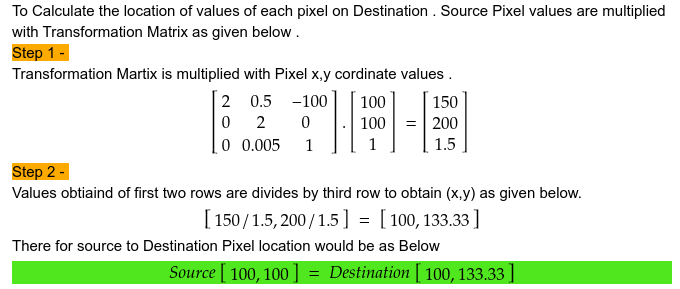

[http://jlouthan.github.io/perspective-transform/examples/test-ui/index.html](http://jlouthan.github.io/perspective-transform/examples/test-ui/index.html)

In [ ]:
# Definimos los puntos de las esquinas del papel
# Dibujamos los puntos y el poligono en la imagen
puntos = np.float32([[750,1190],[2400,1190],[2990,3763],[180,3763]])

imgDibujo = img.copy()

for i in range(0, 4):
  cv2.circle(imgDibujo, tuple(puntos[i].astype(int)), 30, (255,0,0), -1)

pts = puntos.reshape((-1,1,2))
cv2.polylines(imgDibujo, [pts.astype(np.int32)], True, (0,255,0), thickness=10)

fig = px.imshow(imgDibujo)
fig.show()

In [ ]:
width = 500
height = 700

# Definimos la transformacion en base a la imagen de recuperación
dst = np.float32([[0,0],[width,0],[width,height],[0,height]])

# Calcular la transformación
M = cv2.getPerspectiveTransform(puntos, dst)

# Aplicación la transformación
warp = cv2.warpPerspective(img, M, (width, height))

px.imshow(warp).show()

## Propuesto

Utilizando la transformación de perspectiva, proyectar en el plano el cuadro de la siguiente imagen:

In [ ]:
!wget https://apreciart.pe/media/catalog/product/cache/af9c5e85c8c99e6ae7e7dd8629afde29/6/1/cuadro-la-mona-lisa.jpg

--2025-08-29 19:32:52--  https://apreciart.pe/media/catalog/product/cache/af9c5e85c8c99e6ae7e7dd8629afde29/6/1/cuadro-la-mona-lisa.jpg
Resolving apreciart.pe (apreciart.pe)... 104.21.72.119, 172.67.183.181, 2606:4700:3033::6815:4877, ...
Connecting to apreciart.pe (apreciart.pe)|104.21.72.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘cuadro-la-mona-lisa.jpg.1’

cuadro-la-mona-lisa     [ <=>                ]  55.13K  --.-KB/s    in 0.003s  

2025-08-29 19:32:52 (20.6 MB/s) - ‘cuadro-la-mona-lisa.jpg.1’ saved [56452]



In [ ]:
img = cv2.imread("cuadro-la-mona-lisa.jpg")
img = img[:,:,::-1]
px.imshow(img).show()

In [ ]:
puntos = np.float32([[170,140],[522,107],[505,643],[161,616]])

imgDibujo = img.copy()

for i in range(0, 4):
  cv2.circle(imgDibujo, tuple(puntos[i].astype(int)), 30, (255,0,0), -1)

pts = puntos.reshape((-1,1,2))
cv2.polylines(imgDibujo, [pts.astype(np.int32)], True, (0,255,0), thickness=10)

fig = px.imshow(imgDibujo)
fig.show()

In [ ]:
width = 500
height = 700

# Definimos la transformacion en base a la imagen de recuperación
dst = np.float32([[0,0],[width,0],[width,height],[0,height]])

# Calcular la transformación
M = cv2.getPerspectiveTransform(puntos, dst)

# Aplicación la transformación
warp = cv2.warpPerspective(img, M, (width, height))

px.imshow(warp).show()

# Features

Ahora estudiamos como extraer features de una imagen.

In [ ]:
from matplotlib import pyplot as plt

Usando Harris

Harris utiliza un *blocksize* que es el tamaño de la vecindad local (ventana cuadrada) alrededor de cada píxel donde se calcula la mátriz de autocorrelación de gradientes.

Mientras más grande la ventana, más "contexto" se usa, pero también se suavizan detalles finos -> menos sensibilidad a esquinas pequeñas.

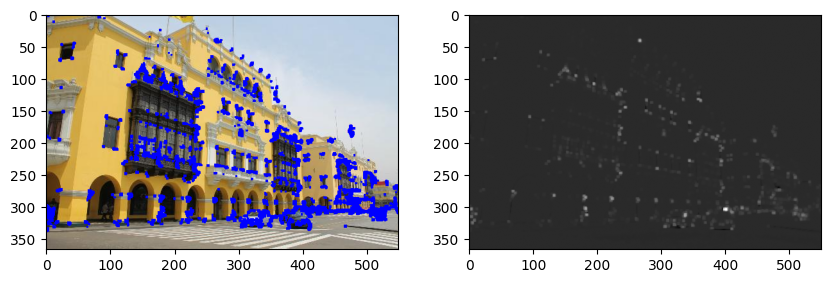

In [ ]:
input_image = cv2.imread('Imagenes/centro1.jpg')
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
harris_test = input_image.copy()

gray = cv2.cvtColor(harris_test, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)

# Tamaño de la ventana local donde se analiza la variación de intensidad
blocksize = 4
# Tamaño del filtro Sobel
kernel_size = 3
dst = cv2.cornerHarris(gray, blocksize, kernel_size, 0.05) # 0.05: sensibildiad

# Expone los puntos detectados
dst = cv2.dilate(dst,None)
# Colorear píxeles con respuesta más fuerte
harris_test[dst>0.01*dst.max()] = [0,0,255]

plt.figure(figsize=(10,10))
plt.subplot(1,2,1), plt.imshow(harris_test)
plt.subplot(1,2,2), plt.imshow(dst, cmap='gray')
plt.show()

Usando SIFT

Construye un espacio de escala con filtros Gaussianos y detecta puntos clave en los máximos/mínimos de la diferencia de gaussianas.

In [ ]:
pip install opencv-contrib-python

Number features: 1449


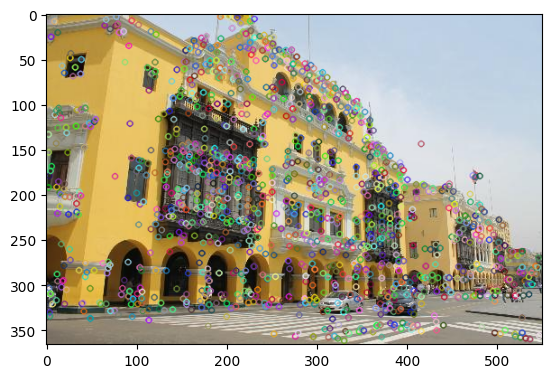

In [ ]:
orbimg = input_image.copy()

# Inicializamos el detector de SIFT
orb = cv2.SIFT_create()

# Busca keypoints en la imagen
kp = orb.detect(orbimg, None)
# Para cada keypoint se calcula su descriptor SIFT
kp, des = orb.compute(orbimg, kp)

print('Number features:', len(kp))

cv2.drawKeypoints(orbimg, kp, orbimg)
plt.imshow(orbimg)
plt.show()

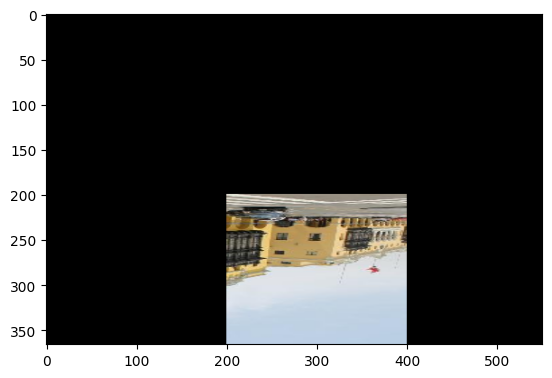

In [ ]:
img2match = np.zeros(input_image.shape, np.uint8)

# Tomamos un recorte de la imagen original
roi = input_image[0:366, 366:500]
roi = cv2.resize(roi, (200,166))

# Dentro del lienzo reservar una área
img2match[0:200,300:500] = [0,0,0]
roi = cv2.flip(roi, 0)

# Pegar el recorte dentro del lienzo
img2match[200:200+roi.shape[0], 200:200+roi.shape[1]] = roi

plt.imshow(img2match)
plt.show()

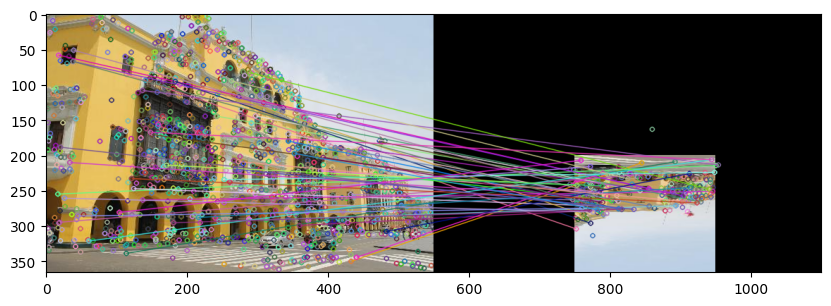

In [ ]:
# Detecta keypoints en la imagen
kp2 = orb.detect(img2match, None)
kp2, des2 = orb.compute(img2match, kp2)

# Crea un emparejamiento por fuerza bruta: Compara cada descriptor de la primera
# imagen contra todos los de la segunda imagen.
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches = bf.match(des, des2)

# Ordena las correspondencias por la distancia entre descriptores
matches = sorted(matches, key = lambda x:x.distance)
# Dibuja las mejores correspondencias
oimg = cv2.drawMatches(orbimg, kp, img2match, kp2, matches[:50], orbimg)

plt.figure(figsize=(10,10))
plt.imshow(oimg)
plt.show()